# Main Code

This notebook reproduces the key simulations and figures from the paper:

#### **Quantifying Resilience in Non-Autonomous and Stochastic Earth System Dynamics with Application to Glacial-Interglacial Cycles**  
*Jakob Harteg et al., in review at Earth System Dynamics (2025)*

Potsdam Institute for Climate Impact Research

---

It runs a conceptual model of the Earth's climate system (based on Talento & Ganopolski, 2021) and quantifies resilience using two complementary metrics:

- **Reference Adherence Ratio (RAR)**: Fraction of stochastic ensemble members that remain close to the unperturbed trajectory.
- **Return time**: Time a single perturbed trajectory takes to return to the reference path.

The notebook:
- Loads and runs the model
- Applies stochastic and single-event perturbations
- Computes resilience metrics
- Reproduces the plots presented in the manuscript

---

In [ ]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from cmcrameri import cm  # scientific colormaps
import pandas as pd

# local imports
from model import model, load_paleo_data, load_orbital_forcing, frequency_spectra, compute_RAR, run_recovery_times_experiment
from plotting import get_MIS_boundaries, add_abc_labels, add_text_to_ax, plots, remove_spine, remove_tick, remove_spines, remove_ticks, plot_MIS_boudnaries, C1, C2, grids

import matplotlib as mpl

# Full-width figure for ESD (13.5 cm = 5.3 inches)
fig_width_cm = 13.5
fig_width_in = fig_width_cm / 2.54
fig_height_in = fig_width_in * 0.75  # aspect ratio

# Apply clean style
mpl.rcParams.update(
    {
        "figure.figsize": (fig_width_in, fig_height_in),
        "font.size": 8,  # base font size
        "axes.labelsize": 9,
        "axes.titlesize": 9,
        "xtick.labelsize": 8,
        "ytick.labelsize": 8,
        "legend.fontsize": 8,
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial"],  # or Helvetica
        "pdf.fonttype": 42,
        "ps.fonttype": 42,
        "savefig.dpi": 600,
        "figure.dpi": 300,
        "axes.linewidth": 0.8,
        "xtick.major.width": 0.6,
        "ytick.major.width": 0.6,
    }
)


In [3]:
mis_boundaries = get_MIS_boundaries()

m1 = model().run()
m1k = model(sigma=0.001).run_ensemble(1_000)
m20k = model(sigma=0.001).run_ensemble(20_000)

# Model plot

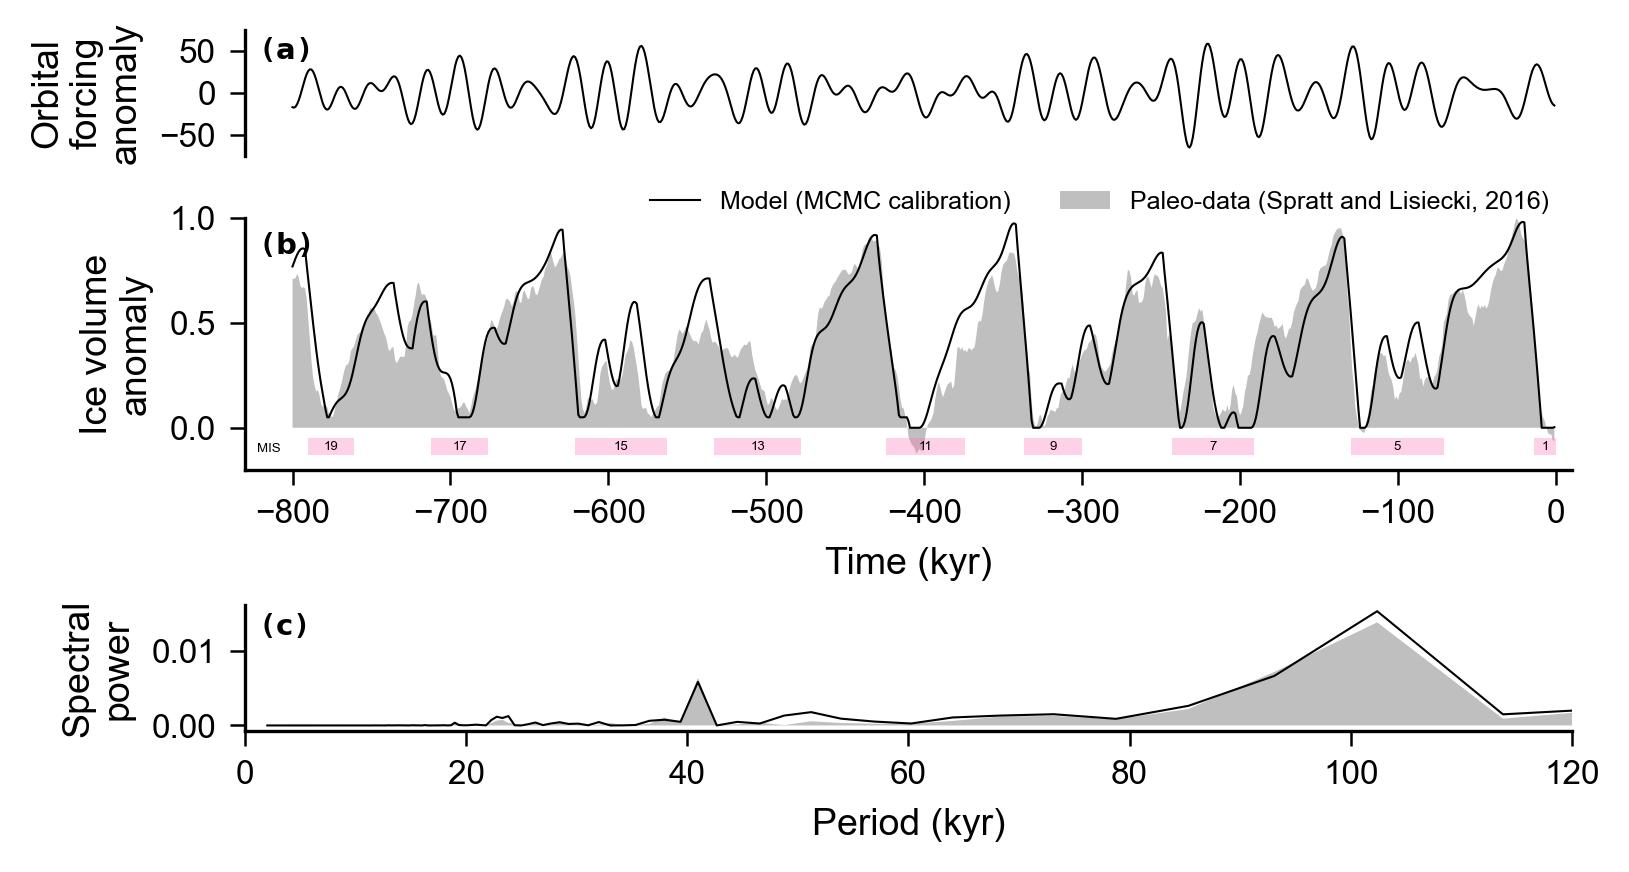

In [4]:
fig, axs = plots(3,1, h_ratios=[1,2,1], w=fig_width_in, h=fig_height_in * 0.7)
paleo = load_paleo_data()

# f
f = load_orbital_forcing()
axs[0].plot(paleo["time"], f[200:1000]-np.mean(f), color='k', lw=0.5)
axs[0].set_ylabel("Orbital\nforcing\nanomaly")
axs[0].set_ylim(-75, 75)
remove_spine(axs[0], spines=["top", "right", "bottom"])
remove_tick(axs[0], y=False)

# v
axs[1].plot(m1.t_range, m1.v, color="k", lw=0.5, label="Model (MCMC calibration)")
axs[1].fill_between(paleo["time"], paleo["ice_volume"], alpha=0.25, facecolor="k", label="Paleo-data (Spratt and Lisiecki, 2016)", lw=0)
axs[1].set_ylabel("Ice volume\nanomaly")
axs[1].set_xlabel("Time (kyr)")
axs[1].set_ylim(-0.2, 1)
plot_MIS_boudnaries(axs[1], font_scale=0.5, only_interglacial=True, alpha=0.3)

# misc
# fig.legend(loc="outside upper right", framealpha=0, ncols=2, fontsize=6)
axs[1].legend(loc="upper right", framealpha=0, ncols=2, fontsize=6, bbox_to_anchor=(1, 1.2))

# New plot frequency spectrum
axs[2].set_xlabel("Period (kyr)")
axs[2].set_ylabel("Spectral\npower")
axs[2].set_xlim(0, 120) 
freq_x, freq_y = frequency_spectra(m1.v)
axs[2].plot(freq_x, freq_y, color="k", lw=0.5)
freq_x, freq_y = frequency_spectra(paleo["ice_volume"])
axs[2].fill_between(freq_x, freq_y, color="k", alpha=0.25, lw=0)

remove_spine(axs[1])
remove_spine(axs[2])

add_abc_labels(axs, add_brackets=True)

axs[1].sharex(axs[0])
axs[1].set_xlim(-830, 10)

plt.savefig("fig_model.pdf", bbox_inches="tight", dpi=600)

# Reference Adherence Ratio


In [5]:
atol_list = np.arange(0.00005, 0.005, 0.0001)
OR = []
for atol in tqdm(atol_list):
    OR.append(compute_RAR(m1.v, m1k.v, atol))

100%|██████████| 50/50 [00:26<00:00,  1.87it/s]


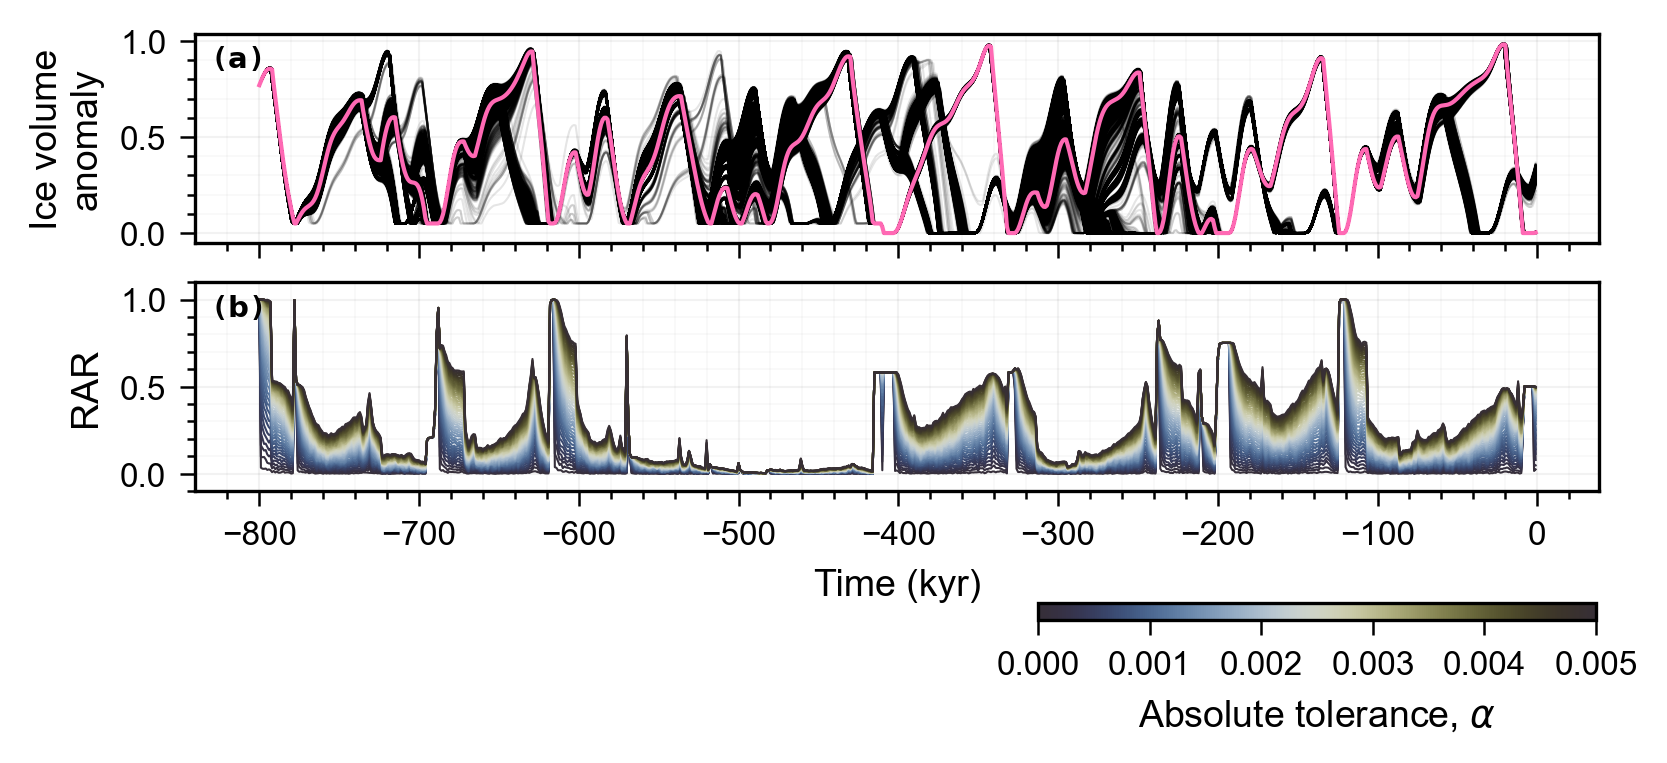

In [6]:
fig, axs = plots(2, 1, sharex=True, w=fig_width_in, h=fig_height_in * 0.5)

[axs[0].plot(m1.t_range, v, color="k", alpha=0.1, lw=0.5, rasterized=True) for v in m20k.v]
axs[0].plot(m1.t_range, m1.v, color=C2, lw=1)

# Create colormap based on atol values
# norm = plt.Normalize(atol_list.min(), atol_list.max())
norm = plt.Normalize(0, 0.005)
cmap = cm.brocO

for i in range(0, len(OR)):
    axs[1].plot(m1.t_range, OR[i], color=cmap(norm(atol_list[i])), lw=0.5, rasterized=True)

# Manually add a colorbar in the lower right below the last subplot
# [left, bottom, width, height] in figure coordinates (0-1)
cbar_width = 0.35
cbar_height = 0.03
cbar_left = 1 - cbar_width - 0.01  # adjust as needed
cbar_bottom = -0.01  # just below the x-axis label

cax = fig.add_axes([cbar_left, cbar_bottom, cbar_width, cbar_height])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
plt.colorbar(sm, cax=cax, orientation="horizontal", label="Absolute tolerance, $\\alpha$")

axs[1].set_ylim(-0.1, 1.1)
axs[-1].set_xlabel("Time (kyr)")
axs[0].set_ylabel("Ice volume\nanomaly") 
axs[1].set_ylabel("RAR")
grids(axs)

add_abc_labels(axs, add_brackets=True)

plt.savefig("fig_rar_sensitivity.pdf", bbox_inches="tight", dpi=600)

In [7]:
def add_plot_details(axs, highlight_mis=False, legend_above=False):
    remove_spine(axs[0], spines=["top", "right", "bottom"])
    remove_tick(axs[0], y=False)
    remove_spine(axs[1], spines=["top", "right"])

    plot_MIS_boudnaries(
        axs[0],
        only_interglacial=True,
        y_offset=1.1,
        label_loc="right",
        label_x_offset=10,
        h=0.15,
        font_scale=0.75,
        alpha=0.3,
    )
    axs[0].set_ylim(-0.1, 1.1)
    axs[-1].set_xlabel("Time (kyr)")
    grids(axs)

    if highlight_mis:
        for ax in axs:
            for mis_i in [0, 10]:
                ax.axvspan(
                    mis_boundaries[0][mis_i],
                    mis_boundaries[0][mis_i + 1],
                    color=C2,
                    alpha=0.3,
                    edgecolor="none",
                )
                if ax == axs[0]:
                    ax.text(
                        (mis_boundaries[0][mis_i] + mis_boundaries[0][mis_i + 1]) / 2,
                        1.2,
                        "MIS11" if mis_i == 10 else "Holocene",
                        ha="center",
                        va="center",
                        fontsize=6,
                    )

    axs[0].set_ylabel("Ice volume\nanomaly")
    axs[1].set_xlabel("Time (kyr)")

    for ax in axs:
        ax.set_xlim(-815, 15)

    if legend_above:
        leg = fig.legend(loc="outside upper right", framealpha=0, ncols=2, bbox_to_anchor=(1.0, 1.1))
        return leg
    else:
        leg1 = axs[0].legend(bbox_to_anchor=(1.0, 0.5), loc="center left", framealpha=0)
        leg2 = axs[1].legend(bbox_to_anchor=(1.0, 0.5), loc="center left", framealpha=0)
        return leg1, leg2

In [8]:
rar = compute_RAR(m1.v, m20k.v, 0.001)

/var/folders/pd/q4f8j97x0gv_zjtmdgf4r3g00000gn/T/ipykernel_42863/2423469571.py:26: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


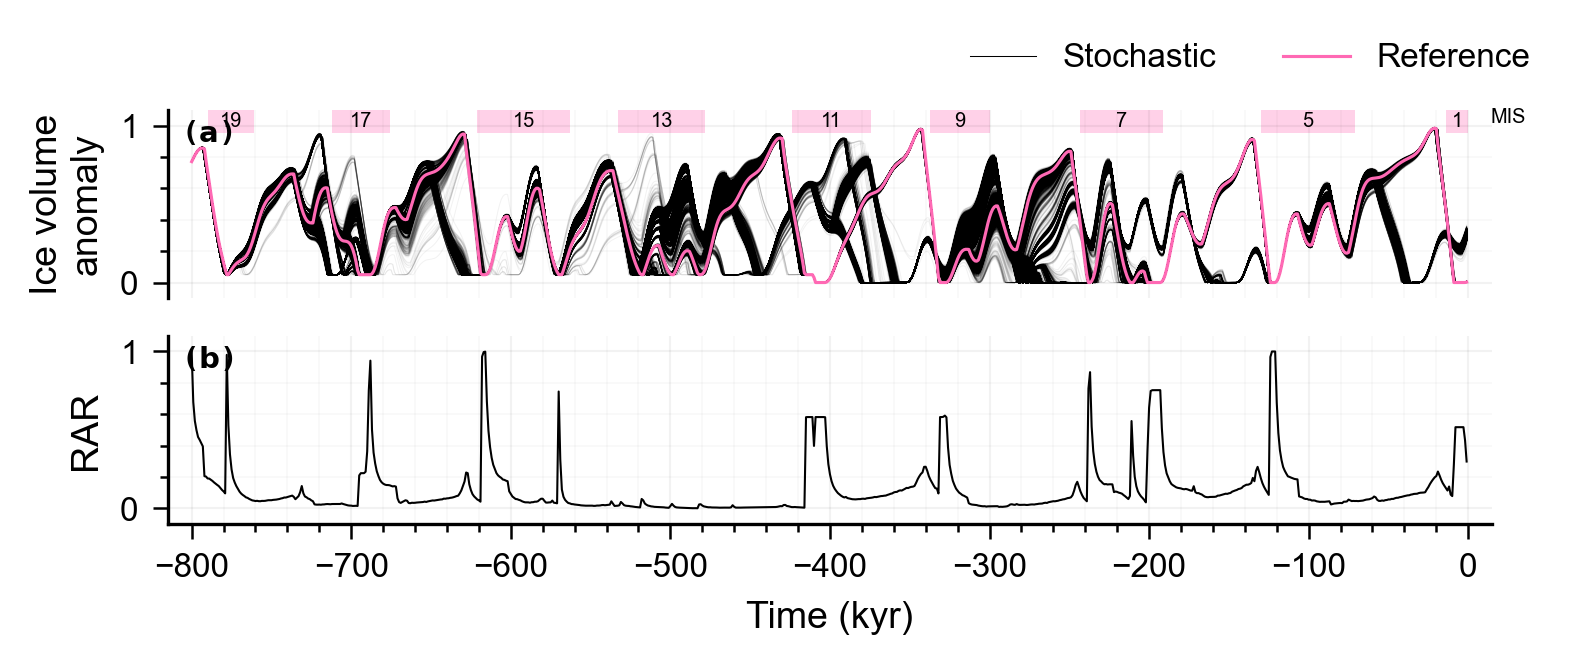

In [15]:
# fig, axs = plots(2, 1, h=PLT_HEIGHT_QUARTER, sharex=True)
fig, axs = plots(2, 1, sharex=True, w=fig_width_in, h=fig_height_in * 0.5)

for i in range(20_000):
    axs[0].plot(
        m1.t_range,
        m20k.v[i],
        color="k",
        alpha=0.05,
        lw=0.25,
        label="Stochastic" if i == 0 else "__no_legend__",
        rasterized=True,
    )
    
axs[0].plot(m1.t_range, m1.v, color=C2, lw=0.75, label="Reference")

axs[1].plot(m1.t_range, rar, color="k", lw=0.5)
axs[1].set_ylim(-0.1, 1.1)
axs[1].set_ylabel("RAR")

leg = add_plot_details(axs, False, legend_above=True)
leg.legend_handles[0].set_alpha(1) # type: ignore

add_abc_labels(axs, add_brackets=True)

plt.tight_layout()

plt.savefig("fig_rar.pdf", bbox_inches="tight", dpi=600)

# Sigma size

In [10]:
sigmas = [0.1, 0.01, 0.001, 0.0001, 0.00001][::-1]
M = []
for s in sigmas:
    M += [model(sigma=s).run_ensemble(500)]

/var/folders/pd/q4f8j97x0gv_zjtmdgf4r3g00000gn/T/ipykernel_42863/606398815.py:33: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


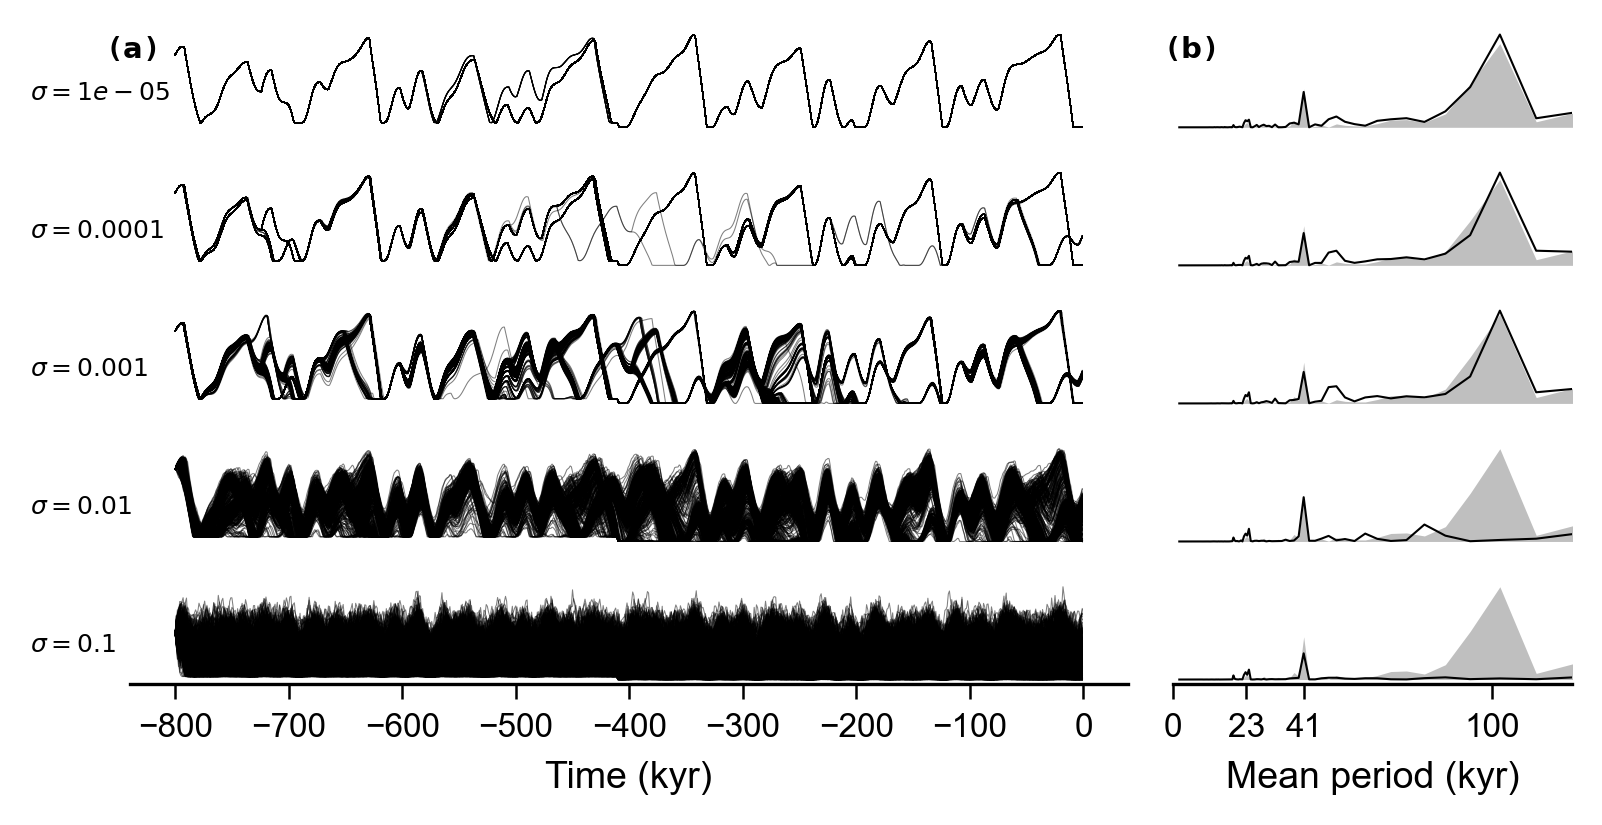

In [11]:
fig, axs = plots(5,2, h=fig_height_in * 0.7, w=fig_width_in, w_ratios=[5,2])
axs = axs.flatten()

remove_spines(axs[:-2], 'all')
remove_ticks(axs[:-2])
remove_ticks(axs[-2:], x=False)
remove_spines(axs[-2:], spines=["left", "right", "top"]) 

plots1 = range(len(axs))[::2]
plots2 = range(len(axs))[1::2]

for j, i in enumerate(plots1):
    m = M[j]
    [axs[i].plot(m.t_range[0], v, lw=0.25, alpha=0.5, color='k', rasterized=True) for v in m.v]
    add_text_to_ax(-0.1, 0.5, fr"$\sigma = {m.sigma}$", ax=axs[i], horizontalalignment="left", fontsize=6)

paleo_freq = frequency_spectra(load_paleo_data()["ice_volume"])

for j, i in enumerate(plots2):
    m = M[j]
    freq_range, P = frequency_spectra(m.ensemble_median())
    axs[i].plot(freq_range, P, color='k', lw=0.5)
    axs[i].fill_between(*paleo_freq, color="k", alpha=0.25, label="Paleo", lw=0)
    axs[i].set_xlim(0, 125)
    axs[i].set_xticks([0, 23, 41, 100])


axs[plots1[-1]].set_xlabel("Time (kyr)")
axs[plots2[-1]].set_xlabel("Mean period (kyr)")

add_abc_labels([axs[0], axs[1]], add_brackets=True, x=-0.025)

plt.tight_layout()
plt.savefig("fig_sigma.pdf", bbox_inches="tight", dpi=900)

# Return time


In [12]:
# run experiment
folder = "return_time_results"
run_recovery_times_experiment(folder = folder)

Computing recovery times


100%|██████████| 800/800 [06:02<00:00,  2.21it/s]


In [13]:
# load experiment results
df = pd.read_csv(f"{folder}/recovery_times.csv")
perturb_v = np.loadtxt(f"{folder}/recovery_times_V.txt", delimiter=",")
m1 = model().run()
mis_boundaries = get_MIS_boundaries()

/var/folders/pd/q4f8j97x0gv_zjtmdgf4r3g00000gn/T/ipykernel_42863/1105828324.py:23: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.axvspan(
/var/folders/pd/q4f8j97x0gv_zjtmdgf4r3g00000gn/T/ipykernel_42863/1530004094.py:29: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


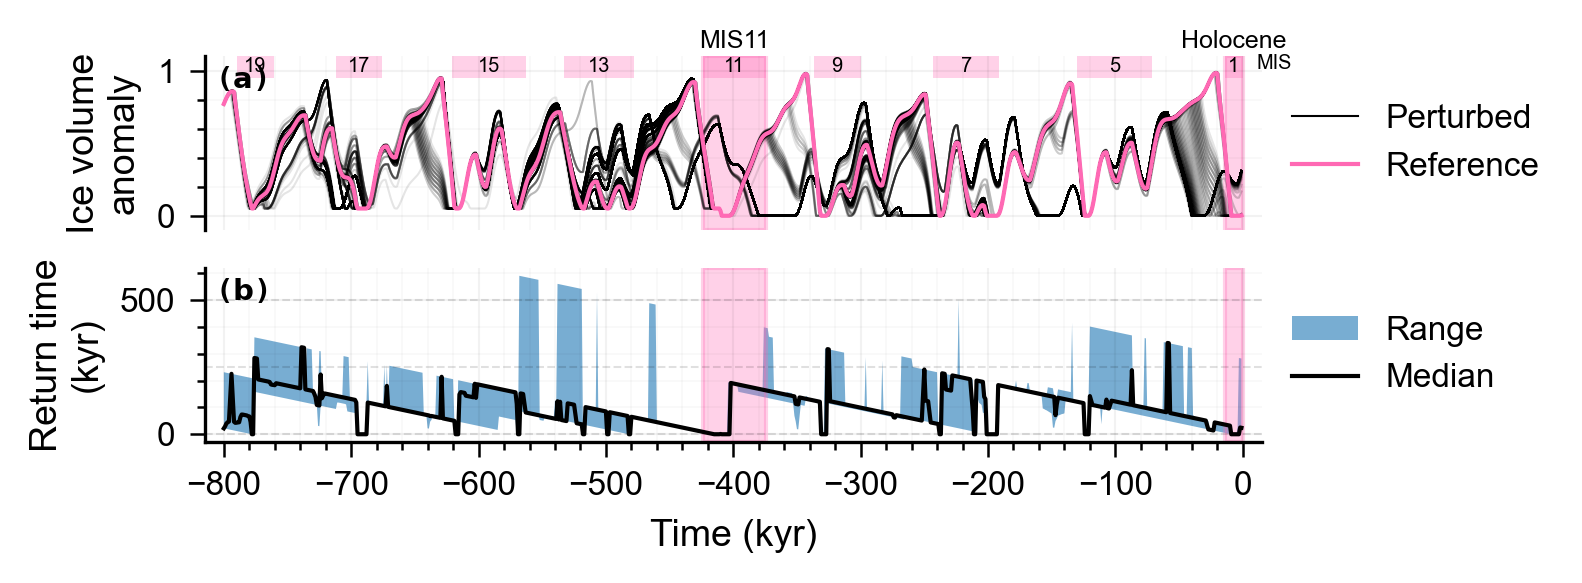

In [14]:
fig, axs = plots(2, 1, sharex=True, w=fig_width_in, h=fig_height_in * 0.5)

for v in perturb_v:
    axs[0].plot(
        np.arange(-800, 0),
        v[:800],
        color="k",
        alpha=0.1,
        lw=0.5,
        rasterized=True,
    )
axs[0].lines[-1].set_label("Perturbed")

axs[0].plot(np.arange(-800, 0), m1.v, C2, lw=1, label="Reference")

axs[1].fill_between(
    df["time"] - 1000, df["L_min"], df["L_max"], label="Range", alpha=0.6
)
axs[1].plot(df["time"] - 1000, df["L_median"], color="k", label="Median", lw=1.0)
axs[1].axhline(0, color="k", lw=0.5, ls="--", alpha=0.12)
axs[1].axhline(250, color="k", lw=0.5, ls="--", alpha=0.12)
axs[1].axhline(500, color="k", lw=0.5, ls="--", alpha=0.12)
axs[1].set_ylabel("Return time\n(kyr)")

leg1, leg2 = add_plot_details(axs, highlight_mis=True)
leg1.legend_handles[0].set_alpha(1)
add_abc_labels(axs, add_brackets=True)

plt.tight_layout()

plt.savefig("fig_return_times.pdf", bbox_inches="tight", dpi=600)